### 1. Load facies models

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

# file path for original facies sections, 64x64x11785 cells
Filepath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/facies_64-64-11785cells' 

##### Read facies model values and convert into an array of 11875x64x64

In [2]:
allele=[]  
# will stores all facies code values of the file. includes 64x64 lists, and each list includes code values of all realizations at each pixel.

with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=4:    # filter the lines with property name "Facies unit1 scale1"        
            allele.append(eles[-1])

faciesimgs = np.array(allele, dtype = float).reshape((-1, 64, 64)).astype(int)
print(faciesimgs.shape)            

(11785, 64, 64)


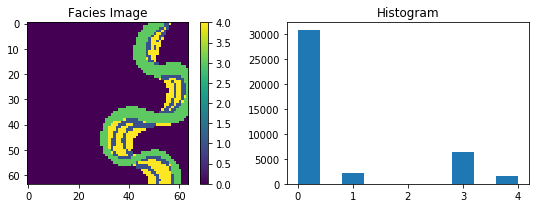

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))  

# First subplot: facies image
im = ax[0].imshow(faciesimgs[11011])
fig.colorbar(im, ax=ax[0]) 
ax[0].set_title("Facies Image")

# Second subplot: histogram
ax[1].hist(faciesimgs[:10].reshape(-1))
ax[1].set_title("Histogram")

plt.tight_layout()
plt.show()


##### These facies models have the facies codes of [0, 1, 3, 4]

* 0: flood plain facies
* 1: mud drape facies
* 3: abandoned channel facies
* 4: sandy lateral accretion facies


* The mud drape and sany lateral accretion facies constitute the point bar facies

### 2. Calculate global features

*For point bar dataset, two global features (point bar-to-channel fill ratio and flood plain proportion) are considered. They are calculated from the facies models.*

#### 2.1 Calculate indicator models of the four facies types

In [4]:
faciesimgs = faciesimgs.reshape(-1, 1, 64, 64)

img_indc_fp = np.where(faciesimgs == 0, 1, 0)
img_indc_md = np.where(faciesimgs == 1, 1, 0)
img_indc_cf = np.where(faciesimgs == 3, 1, 0)  
img_indc_sd = np.where(faciesimgs == 4, 1, 0) 

print(faciesimgs.shape)

(11785, 1, 64, 64)


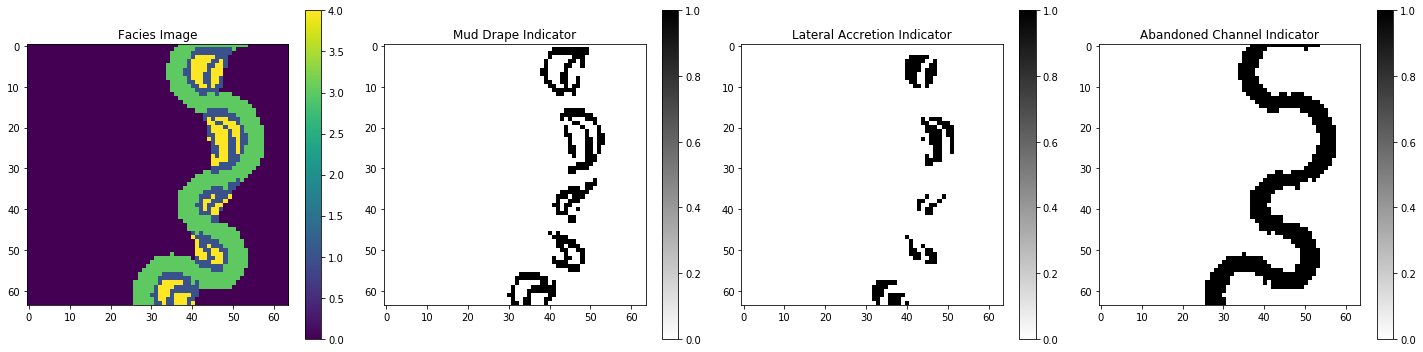

In [5]:
idx = 3  # image index

fig, ax = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

im0 = ax[0].imshow(faciesimgs[idx, 0], cmap='viridis')
ax[0].set_title("Facies Image")
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(img_indc_md[idx, 0], cmap='gray_r')
ax[1].set_title("Mud Drape Indicator")
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(img_indc_sd[idx, 0], cmap='gray_r')
ax[2].set_title("Lateral Accretion Indicator")
fig.colorbar(im2, ax=ax[2])

im3 = ax[3].imshow(img_indc_cf[idx, 0], cmap='gray_r')
ax[3].set_title("Abandoned Channel Indicator")
fig.colorbar(im3, ax=ax[3])

plt.tight_layout()
plt.show()

#### 2.2 Calculate global features from indicator models

In [6]:
# Compute point bar to channel fill ratio. 
# Point bar includes mud drape and sandy lateral accretion; Channel fill refers to abandoned channel facies

mean_md = np.mean(img_indc_md, axis=(1, 2, 3))  # mud drape proportion
mean_sd = np.mean(img_indc_sd, axis=(1, 2, 3))  # sandy lateral accretion proportion
mean_cf = np.mean(img_indc_cf, axis=(1, 2, 3))  # abandoned channel proportion

epsilon = 1e-8  # Avoid division by zero by setting a small epsilon
pb_cf_ratio = (mean_md + mean_sd) / (mean_cf + epsilon)

print("Point bar to channel fill ratio shape:", pb_cf_ratio.shape)

# Compute flood plain proportion
fp_prop = np.mean(img_indc_fp, axis=(1, 2, 3))
print("Flood plain proportion shape:", fp_prop.shape)

# Optional: display summary statistics
print("\nSummary Statistics:")
print(f"PB/CF ratio - mean: {pb_cf_ratio.mean():.3f}, min: {pb_cf_ratio.min():.3f}, max: {pb_cf_ratio.max():.3f}")
print(f"FP proportion - mean: {fp_prop.mean():.3f}, min: {fp_prop.min():.3f}, max: {fp_prop.max():.3f}")


Point bar to channel fill ratio shape: (11785,)
Flood plain proportion shape: (11785,)

Summary Statistics:
PB/CF ratio - mean: 0.859, min: 0.198, max: 5.276
FP proportion - mean: 0.731, min: 0.379, max: 0.829


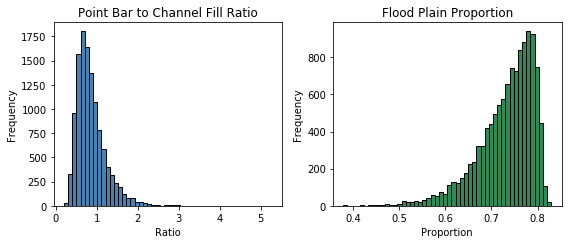

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))  # 1 row, 2 columns

# Histogram of point bar to channel fill ratio
ax[0].hist(pb_cf_ratio, bins=50, color='steelblue', edgecolor='black')
ax[0].set_title("Point Bar to Channel Fill Ratio")
ax[0].set_xlabel("Ratio")
ax[0].set_ylabel("Frequency")

# Histogram of flood plain proportion
ax[1].hist(fp_prop, bins=50, color='seagreen', edgecolor='black')
ax[1].set_title("Flood Plain Proportion")
ax[1].set_xlabel("Proportion")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

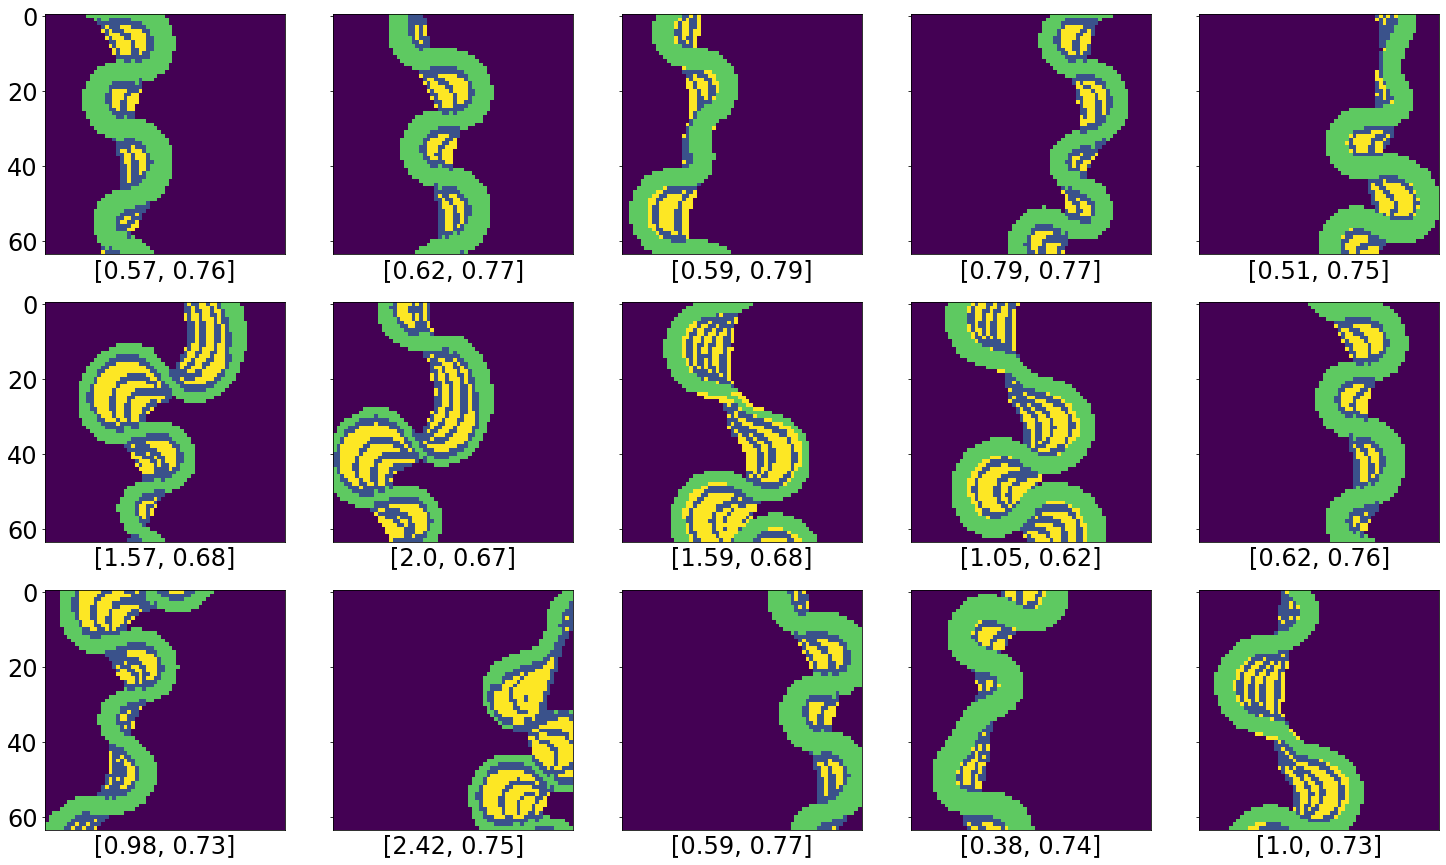

In [8]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(faciesimgs[j,0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{round(pb_cf_ratio[j], 2)}, {str(round(fp_prop[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(faciesimgs[j+15,0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{round(pb_cf_ratio[j+15], 2)}, {str(round(fp_prop[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(faciesimgs[j+25,0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{round(pb_cf_ratio[j+25], 2)}, {str(round(fp_prop[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    
#plt.savefig(recognizer_dir + "Random_15TestFaciesMaps_1.jpg", dpi=200)     

#### 2.3 Normalize these global features into ~[-1, 1]

In [9]:
# Initialize array to store normalized global features
labels_cor = np.empty((faciesimgs.shape[0], 2), dtype=np.float32)

# Normalize point bar to channel fill ratio to ~[-1, 1]
# Approximate original range: [0.2, 2.0]
labels_cor[:, 0] = ((pb_cf_ratio - 0.2) / (2.0 - 0.2) - 0.5) * 2

# Normalize flood plain proportion to ~[-1, 1]
# Approximate orginal range: [0.5, 0.82]
labels_cor[:, 1] = ((fp_prop - 0.5) / (0.82 - 0.5) - 0.5) * 2

### 3. Generate probability maps/cubes for different facies types

*Indicator models --> Add noises --> Gaussian smoothing*

In [10]:
def noise(img, max_noise_size):
    img_x = img.shape[0]
    img_y = img.shape[1]
    img_noise = np.zeros(img.shape)
    # (1) add noise within the facies of indicator = 1 
    noise_num_max = np.round(np.sum(img)/40)
    if noise_num_max>0:       
        ind_indices = np.argwhere(img>=0.9)
        noise_num = np.random.RandomState(13).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(199).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(63).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(8).uniform(-2., 1.5, noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
   
    # (2) add noise within the facies of indicator = 0
    noise_num_max = np.round((img_x*img_y - np.sum(img))/40)
    if noise_num_max>0:
        ind_indices = np.argwhere(img<=0.1)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(0., 1., noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
    return img_noise

In [11]:
# Using Gaussian kernels with various size to smooth the indicator of underground-river-related cave facies to form the probability maps of caves with various blurriness. 
from scipy import ndimage

prob_maps = np.zeros((faciesimgs.shape[0], 3, faciesimgs.shape[2], faciesimgs.shape[3]), dtype=np.float16) 
for num in range(faciesimgs.shape[0]):  
    if num % 100 == 0:
        print(num)  
    k = np.random.RandomState(123).choice([3., 4., 5.])
    cur_indc_md = img_indc_md[num, 0].astype(np.float32)
    cur_indc_cf = img_indc_cf[num, 0].astype(np.float32)
    cur_indc_sd = img_indc_sd[num, 0].astype(np.float32)
    cur_indc_md_noise = noise(cur_indc_md, 6)
    cur_indc_cf_noise = noise(cur_indc_cf, 9) 
    cur_indc_sd_noise = noise(cur_indc_sd, 6)
    cur_noise_prob_md = ndimage.gaussian_filter(cur_indc_md_noise, sigma = (k, k), mode = 'reflect')
    cur_noise_prob_cf = ndimage.gaussian_filter(cur_indc_cf_noise, sigma = (k, k), mode = 'reflect') 
    cur_noise_prob_sd = ndimage.gaussian_filter(cur_indc_sd_noise, sigma = (k, k), mode = 'reflect') 
    prob_md_without_noise = ndimage.gaussian_filter(cur_indc_md, sigma = (k, k), mode = 'reflect') 
    prob_cf_without_noise = ndimage.gaussian_filter(cur_indc_cf, (k, k), mode = 'reflect') 
    prob_sd_without_noise = ndimage.gaussian_filter(cur_indc_sd, (k, k), mode = 'reflect')
    prob_md = prob_md_without_noise + cur_noise_prob_md
    prob_cf = prob_cf_without_noise + cur_noise_prob_cf 
    prob_sd = prob_sd_without_noise + cur_noise_prob_sd 

    prob_sum = prob_md + prob_cf + prob_sd  
    prob_sum_max = np.amax(prob_sum, axis = (0,1))
    if prob_sum_max<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.RandomState(123).rand(1)*0.45+0.25
        prob_md = prob_md * prob_mx / prob_sum_max   
        prob_cf = prob_cf * prob_mx / prob_sum_max 
        prob_sd = prob_sd * prob_mx / prob_sum_max 
    
    if prob_sum_max>0.9: 
        prob_md = prob_md / prob_sum_max * 0.9
        prob_cf = prob_cf / prob_sum_max * 0.9
        prob_sd = prob_sd / prob_sum_max * 0.9
    
    prob_maps[num, 0] = prob_md 
    prob_maps[num, 1] = prob_cf
    prob_maps[num, 2] = prob_sd
    
    prob_maps[num] = np.where(prob_maps[num]<0.02, 0.02, prob_maps[num]) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700


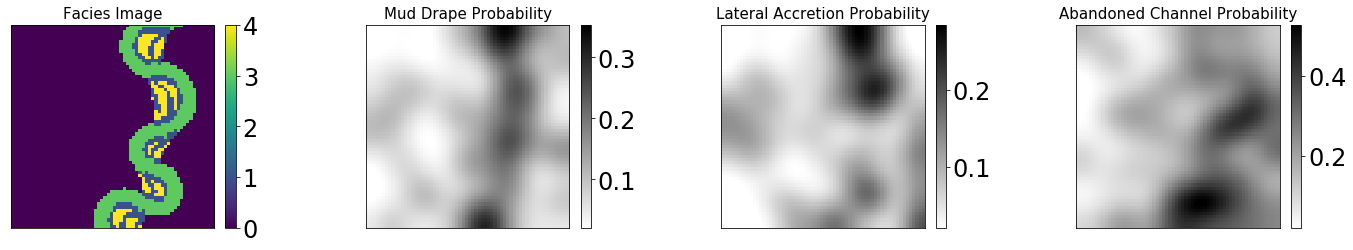

In [12]:
idx = 3  # Sample index to plot

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

# Titles in new order
titles = [
    "Facies Image",
    "Mud Drape Probability",
    "Lateral Accretion Probability",  # moved up
    "Abandoned Channel Probability"   # moved down
]

# Plot facies image
im0 = ax[0].imshow(faciesimgs[idx, 0], cmap='viridis')
ax[0].set_title(titles[0], fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Plot mud drape probability map
im1 = ax[1].imshow(prob_maps[idx, 0].astype(np.float32), cmap='gray_r')
ax[1].set_title(titles[1], fontsize=15)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# Plot lateral accretion probability map (now third)
im2 = ax[2].imshow(prob_maps[idx, 2].astype(np.float32), cmap='gray_r')
ax[2].set_title(titles[2], fontsize=15)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Plot abandoned channel probability map (now fourth)
im3 = ax[3].imshow(prob_maps[idx, 1].astype(np.float32), cmap='gray_r')
ax[3].set_title(titles[3], fontsize=15)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

# Remove axis ticks and tighten layout
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()


### 4. Generate well facies data from facies models

<pre><b>
------------------------ Workflow ------------------------
1. For each facies model:
    - Sample the number of wells (1 to 10)
    - Randomly sample well locations (x, y)
    - Set well indicator to 1 at those locations
2. Multiply facies model with well location mask to get well facies
3. Add well indicator (1) to facies code to distinguish well facies values
----------------------------------------------------------
</b></pre>


In [13]:


# Initialize binary well indicator cube (same shape as facies models)
well_points = np.zeros(faciesimgs.shape, dtype=np.int8)

# Generate well point indicators
for i in range(faciesimgs.shape[0]):
    # Randomly select number of wells (from 1 to 10) for this sample
    well_points_num = np.random.RandomState(3 * i + i * i).choice(np.arange(1, 11), 1)[0]
    
    # Randomly select well x and y coordinates
    xs = np.random.RandomState(123 * i).choice(faciesimgs.shape[2], well_points_num)
    ys = np.random.RandomState(3 * i + i * i).choice(faciesimgs.shape[3], well_points_num)
    
    # Assign 1 to selected well positions in the well indicator volume
    well_points[i, 0, xs, ys] = 1

# Multiply facies model with well indicator to extract facies at well locations
well_facies = faciesimgs * well_points

# Add 1 to all well facies locations
# Final encoding: 0 = non-well, 1 = floodplain, 2 = mud drape, 4 = abandoned channel, 5 = sandy accretion
well_facies = well_facies + well_points

# Shape confirmation
print("well_facies shape:", well_facies.shape)


well_facies shape: (11785, 1, 64, 64)


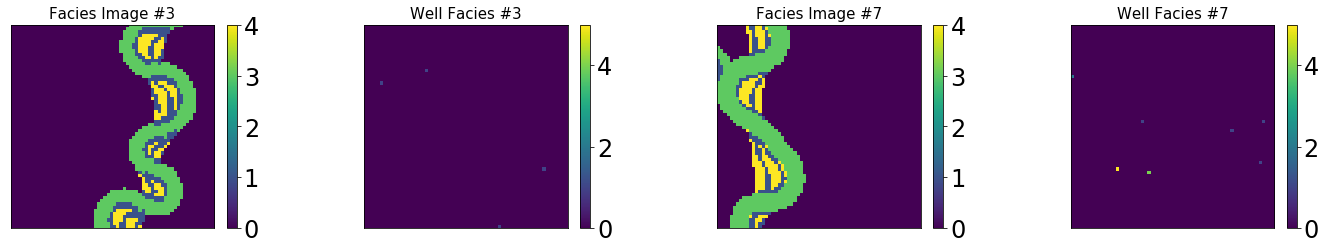

In [14]:
# Choose two indices to display
idx1, idx2 = 3, 7  

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

# Titles
titles = [
    f"Facies Image #{idx1}",
    f"Well Facies #{idx1}",
    f"Facies Image #{idx2}",
    f"Well Facies #{idx2}"
]

# Plot facies image (idx1)
im0 = ax[0].imshow(faciesimgs[idx1, 0], cmap='viridis')
ax[0].set_title(titles[0], fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Plot well facies (idx1)
im1 = ax[1].imshow(well_facies[idx1, 0], vmin=0, vmax=5)
ax[1].set_title(titles[1], fontsize=15)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# Plot facies image (idx2)
im2 = ax[2].imshow(faciesimgs[idx2, 0], cmap='viridis')
ax[2].set_title(titles[2], fontsize=15)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Plot well facies (idx2)
im3 = ax[3].imshow(well_facies[idx2, 0], vmin=0, vmax=5)
ax[3].set_title(titles[3], fontsize=15)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

# Clean up
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

### 5. Split into training and test datasets

In [15]:
# Generate a random permutation of indices
randseq = np.random.RandomState(232).permutation(faciesimgs.shape[0])

# ------------------------ Split facies models ------------------------
faciesimgs_train = faciesimgs[randseq[:10000]]
faciesimgs_test = faciesimgs[randseq[10000:]]

# ------------------------ Split global features ------------------------
labels_cor_train = labels_cor[randseq[:10000]]
labels_cor_test = labels_cor[randseq[10000:]]

# ------------------------ Split probability maps ------------------------
prob_maps_train = prob_maps[randseq[:10000]]
prob_maps_test = prob_maps[randseq[10000:]]

# ------------------------ Split well facies data ------------------------
well_facies_train = well_facies[randseq[:10000]]
well_facies_test = well_facies[randseq[10000:]]

# ------------------------ Print shapes to verify ------------------------
print("Facies:", faciesimgs_train.shape, faciesimgs_test.shape)
print("Global features:", labels_cor_train.shape, labels_cor_test.shape)
print("Probability maps:", prob_maps_train.shape, prob_maps_test.shape)
print("Well facies:", well_facies_train.shape, well_facies_test.shape)

Facies: (10000, 1, 64, 64) (1785, 1, 64, 64)
Global features: (10000, 2) (1785, 2)
Probability maps: (10000, 3, 64, 64) (1785, 3, 64, 64)
Well facies: (10000, 1, 64, 64) (1785, 1, 64, 64)


Normalized global features [Train #4556]: [-0.62539685  0.4831543 ]
Normalized global features [Test #1315]: [1.0315654 0.4984131]


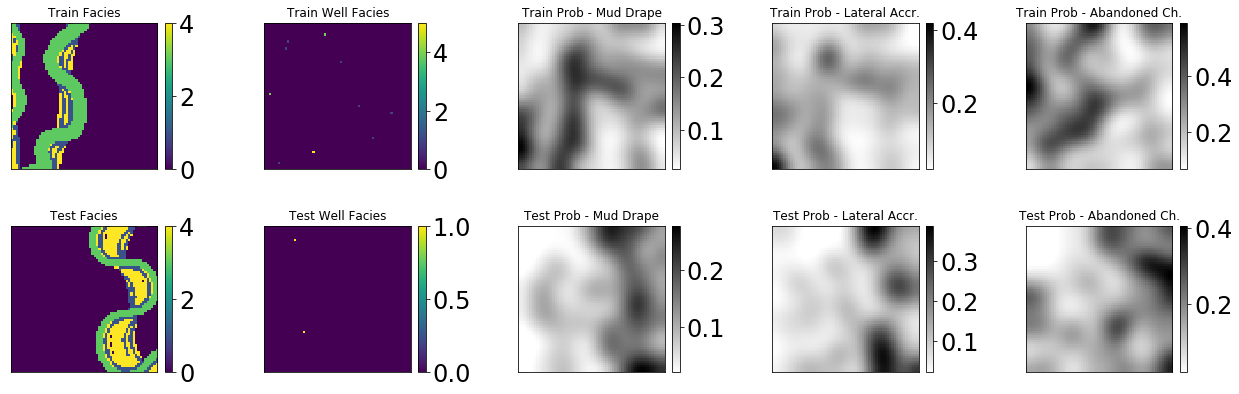

In [16]:
import matplotlib.pyplot as plt

# Random indices
i_train = np.random.randint(0, faciesimgs_train.shape[0])
i_test = np.random.randint(0, faciesimgs_test.shape[0])

# Print normalized global features
print(f"Normalized global features [Train #{i_train}]:", labels_cor_train[i_train])
print(f"Normalized global features [Test #{i_test}]:", labels_cor_test[i_test])

# Create plot with 2 rows and 5 columns
fig, ax = plt.subplots(2, 5, figsize=(18, 6))
title_fontsize = 12 

# ----------- Row 0: Training sample -----------

# Facies image
im00 = ax[0, 0].imshow(faciesimgs_train[i_train, 0])
ax[0, 0].set_title("Train Facies", fontsize=title_fontsize)
fig.colorbar(im00, ax=ax[0, 0], fraction=0.046, pad=0.04)

# Well facies
im01 = ax[0, 1].imshow(well_facies_train[i_train, 0])
ax[0, 1].set_title("Train Well Facies", fontsize=title_fontsize)
fig.colorbar(im01, ax=ax[0, 1], fraction=0.046, pad=0.04)

# Mud drape prob
im02 = ax[0, 2].imshow(prob_maps_train[i_train, 0].astype(np.float32), cmap='gray_r')
ax[0, 2].set_title("Train Prob - Mud Drape", fontsize=title_fontsize)
fig.colorbar(im02, ax=ax[0, 2], fraction=0.046, pad=0.04)

# Lateral accretion prob
im03 = ax[0, 3].imshow(prob_maps_train[i_train, 2].astype(np.float32), cmap='gray_r')
ax[0, 3].set_title("Train Prob - Lateral Accr.", fontsize=title_fontsize)
fig.colorbar(im03, ax=ax[0, 3], fraction=0.046, pad=0.04)

# Abandoned channel prob
im04 = ax[0, 4].imshow(prob_maps_train[i_train, 1].astype(np.float32), cmap='gray_r')
ax[0, 4].set_title("Train Prob - Abandoned Ch.", fontsize=title_fontsize)
fig.colorbar(im04, ax=ax[0, 4], fraction=0.046, pad=0.04)

# ----------- Row 1: Test sample -----------

# Facies image
im10 = ax[1, 0].imshow(faciesimgs_test[i_test, 0])
ax[1, 0].set_title("Test Facies", fontsize=title_fontsize)
fig.colorbar(im10, ax=ax[1, 0], fraction=0.046, pad=0.04)

# Well facies
im11 = ax[1, 1].imshow(well_facies_test[i_test, 0])
ax[1, 1].set_title("Test Well Facies", fontsize=title_fontsize)
fig.colorbar(im11, ax=ax[1, 1], fraction=0.046, pad=0.04)

# Mud drape prob
im12 = ax[1, 2].imshow(prob_maps_test[i_test, 0].astype(np.float32), cmap='gray_r')
ax[1, 2].set_title("Test Prob - Mud Drape", fontsize=title_fontsize)
fig.colorbar(im12, ax=ax[1, 2], fraction=0.046, pad=0.04)

# Lateral accretion prob
im13 = ax[1, 3].imshow(prob_maps_test[i_test, 2].astype(np.float32), cmap='gray_r')
ax[1, 3].set_title("Test Prob - Lateral Accr.", fontsize=title_fontsize)
fig.colorbar(im13, ax=ax[1, 3], fraction=0.046, pad=0.04)

# Abandoned channel prob
im14 = ax[1, 4].imshow(prob_maps_test[i_test, 1].astype(np.float32), cmap='gray_r')
ax[1, 4].set_title("Test Prob - Abandoned Ch.", fontsize=title_fontsize)
fig.colorbar(im14, ax=ax[1, 4], fraction=0.046, pad=0.04)

# Clean ticks
for a_row in ax:
    for a in a_row:
        a.set_xticks([])
        a.set_yticks([])

plt.tight_layout()
plt.show()


### 6. Store dataset for training GANSim

*Note: When downsampling the facies models into coarser resolutions, a downsampling method with facies priority is used. In this point bar dataset, the priority order is set as: abandoned channel (code 3) > sandy lateral accretion (code 4) > mud drape (code 1) > floodplain (code 0). This ensures that higher-priority geological features are preserved during resolution reduction — for example, if any pixel in a downsampling block contains an abandoned channel, the entire block is assigned that facies in the downsampled image.*

In [17]:
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_images, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_images    = expected_images
        self.cur_images         = 0
        self.shape              = None
        self.resolution_log2    = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert os.path.isdir(self.tfrecord_dir)

    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d images.' % self.cur_images)

    def choose_shuffled_order(self):  # Note: Images and labels must be added in shuffled order.
        order = np.arange(self.expected_images)
        np.random.RandomState(123).shuffle(order)
        return order

    def add_real_image(self, real_img):
        def downscale_factor(img):
            img_dim = img.shape[1:]
            img_dim_log2 = np.log2(img_dim).astype(int)
            img_dim_log2_dist = img_dim_log2 - np.array([2, 2])
            down_factor = np.where(img_dim_log2_dist > 0, 2, 1)
            return down_factor

        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = real_img.shape
            self.resolution_log2 = int(np.log2(self.shape[1]))
            assert self.shape[0] in [1, 3]
            assert self.shape[1] == self.shape[2]
            assert self.shape[1] == 2 ** self.resolution_log2
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.resolution_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.resolution_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        assert real_img.shape == self.shape

        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_img = real_img.astype(np.float32)
                fac_x, fac_y = downscale_factor(real_img)

                # Perform facies-priority-based downsampling to lower resolution:
                # (1) Re-encode facies values using descending priority values.
                #     For the point bar dataset, the priority is: abandoned channel (3) > sandy accretion (4) > mud drape (1) > floodplain (0).
                #     Replace each facies code with a temporary decreasing numerical code (e.g., 99, 98, ...), reflecting its priority.
                prior_codes = [3, 4, 1, 0]
                dec_codes = [99. - i for i in range(len(prior_codes))]

                # (2) Replace facies codes in the image with their corresponding priority values
                for code, dec_code in zip(prior_codes, dec_codes):
                    real_img = np.where(real_img == code, dec_code, real_img)

                real_img = np.expand_dims(real_img, axis=-1)

                # (3) Perform 2D downsampling using a block-wise max operation
                real_img = np.concatenate(
                    (
                        real_img[:, 0::fac_x, 0::fac_y],
                        real_img[:, 0::fac_x, fac_y - 1::fac_y],
                        real_img[:, fac_x - 1::fac_x, 0::fac_y],
                        real_img[:, fac_x - 1::fac_x, fac_y - 1::fac_y]
                    ),
                    axis=-1
                )
                real_img = np.max(real_img, axis=-1)

                # (4) Convert temporary priority codes back to original facies codes
                for code, dec_code in zip(prior_codes, dec_codes):
                    real_img = np.where(real_img == dec_code, code, real_img)

            quant = np.rint(real_img).clip(0, 255).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
            }))
            tfr_writer.write(ex.SerializeToString())
        self.cur_images += 1

    def add_prob_image(self, prob_image):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = prob_image.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            tfr_file = self.tfr_prefix + '-2probimages.tfrecords'
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        quant = prob_image.clip(0, 1).astype(np.float16)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
        }))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1

    def add_well_facies(self, well_facies):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)

        if self.shape is None:
            self.shape = well_facies.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            tfr_file = self.tfr_prefix + '-3wellfacies.tfrecords'
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))

        quant = well_facies.astype(np.uint8)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))
        }))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1

    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        assert labels.shape[0] == self.cur_images
        with open(self.tfr_prefix + '-4rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()


In [18]:
# Path for saving TFRecords of the training dataset
tfrecord_dir_training = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TrainingData'

# Path for saving TFRecords of the test dataset
tfrecord_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TestData'

In [19]:
with TFRecordExporter(tfrecord_dir_training, faciesimgs_train.shape[0]) as tfr:
    for idx in range(faciesimgs_train.shape[0]):
        tfr.add_real_image(faciesimgs_train[idx])
    tfr.add_labels(labels_cor_train)       

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TrainingData"
Added 10000 images.                     


In [20]:
with TFRecordExporter(tfrecord_dir_training, prob_maps_train.shape[0]) as tfr:
    for idx in range(prob_maps_train.shape[0]):
        tfr.add_prob_image(prob_maps_train[idx])     

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TrainingData"
Added 10000 images.                     


In [21]:
with TFRecordExporter(tfrecord_dir_training, well_facies_train.shape[0]) as tfr:
    for idx in range(well_facies_train.shape[0]):
        tfr.add_well_facies(well_facies_train[idx])     

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TrainingData"
Added 10000 images.                     


#### Store test dataset

In [22]:
 
with TFRecordExporter(tfrecord_dir_test, faciesimgs_test.shape[0]) as tfr:
    for idx in range(faciesimgs_test.shape[0]):
        tfr.add_real_image(faciesimgs_test[idx])
    tfr.add_labels(labels_cor_test)


Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TestData"
Added 1785 images.                      


In [23]:
with TFRecordExporter(tfrecord_dir_test, prob_maps_test.shape[0]) as tfr:
    for idx in range(prob_maps_test.shape[0]):
        tfr.add_prob_image(prob_maps_test[idx])
   

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TestData"
Added 1785 images.                      


In [24]:
with TFRecordExporter(tfrecord_dir_test, well_facies_test.shape[0]) as tfr:
    for idx in range(well_facies_test.shape[0]):
        tfr.add_well_facies(well_facies_test[idx])
   

Creating dataset "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/TestData"
Added 1785 images.                      
